# ML Zoomcamp Cohort 2024
# Homework 3

Imports

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score

### Dataset

In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

Or you can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
```

We need to take `bank/bank-full.csv` file from the downloaded zip-file.  
In this dataset our desired target for classification task will be `y` variable - has the client subscribed a term deposit or not. 

### Features

For the rest of the homework, you'll need to use only these columns:

* `age`,
* `job`,
* `marital`,
* `education`,
* `balance`,
* `housing`,
* `contact`,
* `day`,
* `month`,
* `duration`,
* `campaign`,
* `pdays`,
* `previous`,
* `poutcome`,
* `y`


In [90]:
# !wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

In [91]:
df_bank_full = pd.read_csv("../data/bank/bank-full.csv", sep=';')
df_bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Data preparation

* Select only the features from above.
* Check if the missing values are presented in the features.

In [92]:
df_bank = df_bank_full[['age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y']]
df_bank.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [93]:
df_bank.isna().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### Question 1

What is the most frequent observation (mode) for the column `education`?

- `unknown`
- `primary`
- `secondary`
- `tertiary`

In [94]:
print(f"The most frequent observation in the education feature is: '{df_bank['education'].mode().iloc[0]}'")

The most frequent observation in the education feature is: 'secondary'


### Question 2

Create the [correlation matrix](https://www.google.com/search?q=correlation+matrix) for the numerical features of your dataset. 
In a correlation matrix, you compute the correlation coefficient between every pair of features.

What are the two features that have the biggest correlation?

- `age` and `balance`
- `day` and `campaign`
- `day` and `pdays`
- `pdays` and `previous`


In [95]:
num_features = ['age', 'balance', 'campaign', 'pdays', 'previous']

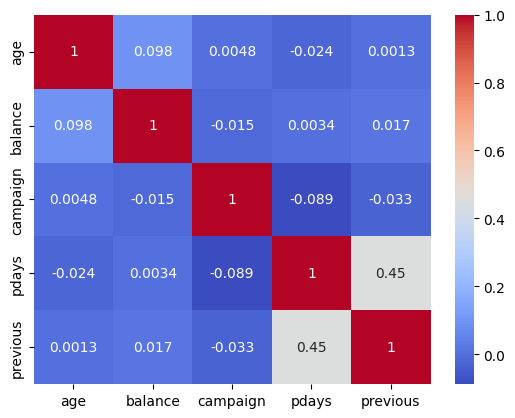

In [96]:
sns.heatmap(df_bank[num_features].corr(), annot=True, cmap='coolwarm')
plt.show()

### Target encoding

* Now we want to encode the `y` variable.
* Let's replace the values `yes`/`no` with `1`/`0`.

In [97]:
df_bank['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [98]:
df_bank.loc[:, 'y'] = df_bank['y'].apply(lambda x: int(1) if x=='yes' else int(0))
df_bank['y'].value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

### Split the data

* Split your data in train/val/test sets with 60%/20%/20% distribution.
* Use Scikit-Learn for that (the `train_test_split` function) and set the seed to `42`.
* Make sure that the target value `y` is not in your dataframe.


In [99]:
# Separate features and target
X = df_bank.drop(columns=['y'])  # Make sure to exclude the target column 'y'
y = df_bank['y']  # The target


# Split into train (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, random_state=42)

# Split temp into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42)



# Output the shapes of the splits to verify
print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Train set: (27126, 14), Validation set: (9042, 14), Test set: (9043, 14)


### Question 3

* Calculate the mutual information score between `y` and other categorical variables in the dataset. Use the training set only.
* Round the scores to 2 decimals using `round(score, 2)`.

Which of these variables has the biggest mutual information score?
  
- `contact`
- `education`
- `housing`
- `poutcome`

In [100]:
# Define the categorical variables of interest
categorical_variables = ['contact', 'education', 'housing', 'poutcome']

# Copy the relevant columns from the training set
X_train_categorical = X_train[categorical_variables].copy()


In [101]:
y_train = y_train.astype(int)
print(y_train.dtype)


int64


In [102]:
# Initialize a dictionary to hold label encoders
label_encoders = {}

# Encode each categorical variable using LabelEncoder
for column in categorical_variables:
    le = LabelEncoder()
    X_train_categorical[column] = le.fit_transform(X_train_categorical[column])
    label_encoders[column] = le

# Calculate the mutual information scores
mi_scores = mutual_info_classif(
    X_train_categorical,
    y_train,
    discrete_features=True,
    random_state=42
)

# Round the mutual information scores to 2 decimal places
mi_scores_rounded = [round(score, 2) for score in mi_scores]

In [103]:
# Create a DataFrame to display the results
mi_results = pd.DataFrame({
    'Variable': categorical_variables,
    'Mutual Information Score': mi_scores_rounded
})

# Display the results
print(mi_results)

# Identify the variable with the highest mutual information score
max_score = mi_results['Mutual Information Score'].max()
max_variable = mi_results.loc[mi_results['Mutual Information Score'] == max_score, 'Variable'].values[0]

print(f"\nThe variable with the highest mutual information score is: **{max_variable}**")

    Variable  Mutual Information Score
0    contact                      0.01
1  education                      0.00
2    housing                      0.01
3   poutcome                      0.03

The variable with the highest mutual information score is: **poutcome**


### Question 4

* Now let's train a logistic regression.
* Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
* Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    - `model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)`
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?

- 0.6
- 0.7
- 0.8
- 0.9

In [104]:
# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)


Numerical columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']


In [105]:
# Convert DataFrames to dictionaries
train_dict = X_train[categorical_cols + numerical_cols].to_dict(orient='records')
val_dict = X_val[categorical_cols + numerical_cols].to_dict(orient='records')

# Initialize the DictVectorizer
dv = DictVectorizer(sparse=False)

# Fit and transform the training data
X_train_encoded = dv.fit_transform(train_dict)

# Transform the validation data
X_val_encoded = dv.transform(val_dict)

In [106]:
# Initialize the model with specified parameters
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

# Fit the model on the training data
model.fit(X_train_encoded, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [107]:
y_val = y_val.astype(int)
print(y_val.dtype)

int64


In [108]:
# Predict probabilities on the validation set
y_pred = model.predict(X_val_encoded)

# Calculate accuracy
accuracy_full = accuracy_score(y_val, y_pred)

# Round to two decimal places
accuracy_rounded = round(accuracy_full, 2)

print(f"Validation Accuracy: {accuracy_rounded}")

Validation Accuracy: 0.9


### Question 5 

* Let's find the least useful feature using the *feature elimination* technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature. 

Which of following feature has the smallest difference?

- `age`
- `balance`
- `marital`
- `previous`

> **Note**: The difference doesn't have to be positive.

In [109]:
# Function to get feature indices in encoded data
def get_feature_indices(feature_name, dv):
    feature_indices = []
    for i, fname in enumerate(dv.feature_names_):
        if fname == feature_name:
            feature_indices.append(i)
        elif fname.startswith(feature_name + '='):
            feature_indices.append(i)
    return feature_indices

In [112]:
# List of features to test
features_to_test = ['age', 'balance', 'marital', 'previous']

# Dictionary to store differences
differences = {}

for feature in features_to_test:
    # Get indices of the feature in encoded data
    feature_indices = get_feature_indices(feature, dv)

    # Remove feature columns from encoded data
    X_train_reduced = np.delete(X_train_encoded, feature_indices, axis=1)
    X_val_reduced = np.delete(X_val_encoded, feature_indices, axis=1)

    # Retrain the model without the feature
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train_reduced, y_train)

    # Predict and calculate validation accuracy
    y_pred = model.predict(X_val_reduced)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation accuracy without '{feature}': {accuracy:.4f}")

    # Calculate difference
    diff = abs(accuracy_full - accuracy)
    differences[feature] = diff
    print(f"Difference in accuracy without '{feature}': {diff:.4f}\n")

Validation accuracy without 'age': 0.9010
Difference in accuracy without 'age': 0.0002

Validation accuracy without 'balance': 0.9008
Difference in accuracy without 'balance': 0.0000

Validation accuracy without 'marital': 0.9011
Difference in accuracy without 'marital': 0.0003

Validation accuracy without 'previous': 0.9007
Difference in accuracy without 'previous': 0.0001



In [113]:
# Identify the feature with the smallest difference
least_impact_feature = min(differences, key=differences.get)
print("Feature with the smallest difference:", least_impact_feature)

Feature with the smallest difference: balance


### Question 6

* Now let's train a regularized logistic regression.
* Let's try the following values of the parameter `C`: `[0.01, 0.1, 1, 10, 100]`.
* Train models using all the features as in Q4.
* Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

Which of these `C` leads to the best accuracy on the validation set?

- 0.01
- 0.1
- 1
- 10
- 100

> **Note**: If there are multiple options, select the smallest `C`

In [119]:
C_values = [0.01, 0.1, 1, 10, 100]
accuracies = {}

for C in C_values:
    # Initialize the model with specified parameters
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)

    # Fit the model on the training data
    model.fit(X_train_encoded, y_train)

    # Predict on the validation set
    y_pred = model.predict(X_val_encoded)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    accuracies[C] = accuracy

    # Print the accuracy rounded to 3 decimal digits
    print(f"C={C}, Validation Accuracy={accuracy:.3f}")

C=0.01, Validation Accuracy=0.899
C=0.1, Validation Accuracy=0.901
C=1, Validation Accuracy=0.901
C=10, Validation Accuracy=0.901
C=100, Validation Accuracy=0.901
